In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# --- 1. Load Data Directly with TensorFlow Datasets ---
(train_dataset, validation_dataset), info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'], # Use 80% for training, 20% for validation
    with_info=True,
    as_supervised=True, # Returns (image, label) tuples
)

# --- 2. Define Constants ---
IMAGE_SIZE = (224, 224) # We can go back to the larger size now!
BATCH_SIZE = 32
class_names = info.features['label'].names
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# --- 3. Create a Preprocessing Function & Apply It ---
def preprocess(image, label):
  image = tf.image.resize(image, IMAGE_SIZE)
  return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato

In [2]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [4]:
model = tf.keras.Sequential([
  data_augmentation,
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [5]:
epochs = 10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 115s 78ms/step - accuracy: 0.4773 - loss: 1.9268 - val_accuracy: 0.5302 - val_loss: 1.6257
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 105s 76ms/step - accuracy: 0.6990 - loss: 1.0130 - val_accuracy: 0.5648 - val_loss: 1.4828
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 104s 76ms/step - accuracy: 0.7301 - loss: 0.8940 - val_accuracy: 0.6080 - val_loss: 1.3486
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 105s 76ms/step - accuracy: 0.7432 - loss: 0.8386 - val_accuracy: 0.5825 - val_loss: 1.4787
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 103s 76ms/step - accuracy: 0.7529 - loss: 0.8020 - val_accuracy: 0.5940 - val_loss: 1.4195
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 105s 76ms/step - accuracy: 0.7575 - loss: 0.7788 - val_accuracy: 0.6074 - val_loss: 1.3698
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 104s 76ms/step - accuracy: 0.7620 - loss: 0.7622 - val_accuracy: 0.5867 - val_loss: 1.4925
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 142s 76ms/step - accuracy: 

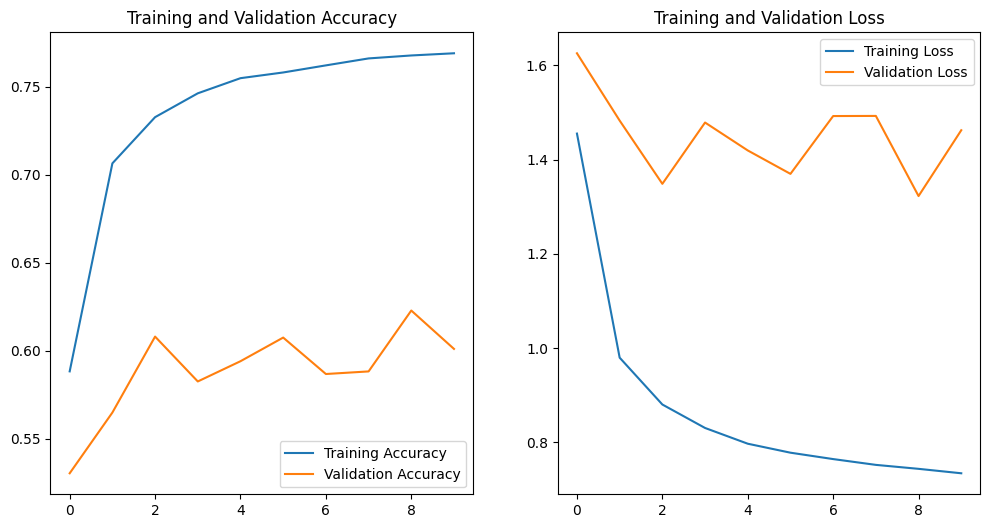

In [6]:
# --- Plot the training history ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [7]:
# Save the model with a clear name
model.save('krishi_mitra_model_baseline.keras')

print("Model has been saved to a file!")

Model has been saved to a file!
